In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

sns.set()

### Preprocessing 

In [3]:
df = pd.read_csv('PastLoans.csv')

In [4]:
df = pd.get_dummies(df)
df = df.drop(['social1', 'social2', 'id'], axis=1)

income data is skewed, take log to flatten histogram

In [6]:
df['log_income'] = np.log(df['income']+1)
df = df.loc[:, df.columns != 'income']

<AxesSubplot:ylabel='Frequency'>

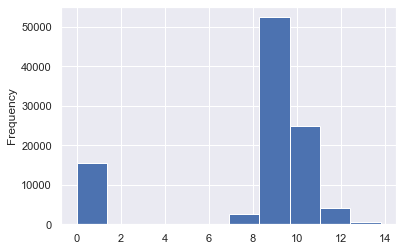

In [7]:
df.log_income.plot.hist()

In [8]:
df.head(5)

,sex,marital,social3,default,employment_employed,employment_retired,employment_student,employment_unemployed,log_income
0,1,0,0.732502,0,0,0,0,1,8.605021
1,1,1,0.615449,0,1,0,0,0,10.170035
2,1,1,0.174645,0,1,0,0,0,9.376787
3,1,1,0.216376,0,0,0,0,1,8.589700
4,0,1,0.346708,1,0,1,0,0,8.149024


In [9]:
df.describe()

,sex,marital,social3,default,employment_employed,employment_retired,employment_student,employment_unemployed,log_income
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.725190,0.610080,0.414410,0.196320,0.614850,0.112030,0.159840,0.113280,8.042560
std,0.446421,0.487734,0.324663,0.397215,0.486633,0.315405,0.366459,0.316936,3.526420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.060052,0.000000,0.000000,0.000000,0.000000,0.000000,8.669227
50%,1.000000,1.000000,0.440763,0.000000,1.000000,0.000000,0.000000,0.000000,9.191259
75%,1.000000,1.000000,0.691053,0.000000,1.000000,0.000000,0.000000,0.000000,9.807981
max,1.000000,1.000000,0.999980,1.000000,1.000000,1.000000,1.000000,1.000000,13.815512


- No missing values
- Mainly male profiles
- Mainly married persons
- Mainly employed 
- 19% of default payments

In [11]:
X = df.loc[:, df.columns != 'default']
y = df['default']

<AxesSubplot:>

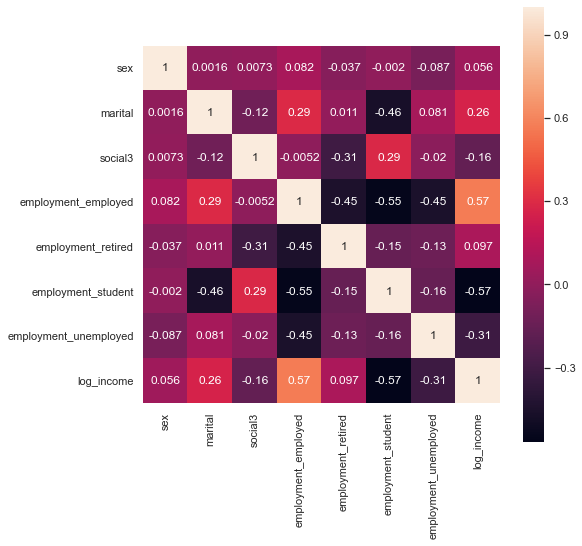

In [12]:
plt.figure(figsize=(8,8))
corrMatrix = X.corr()
sns.heatmap(corrMatrix, annot=True, square=True)

Bit of multicollinearity between the indep variables, we could remove some var to remove coll

## Regression

As target is bin, better to take logistic regression. Tried with OLS and random forest, but results were worse

In [13]:
est = sm.Logit(y, sm.add_constant(X).drop(['employment_employed'], axis=1))
fit = est.fit()
print(fit.summary())

Optimization terminated successfully.
         Current function value: 0.465668
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                default   No. Observations:               100000
Model:                          Logit   Df Residuals:                    99992
Method:                           MLE   Df Model:                            7
Date:                Sat, 23 Apr 2022   Pseudo R-squ.:                 0.05975
Time:                        16:56:55   Log-Likelihood:                -46567.
converged:                       True   LL-Null:                       -49526.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.7261      0.043     17.009      0.000       0.642       0.

In [292]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print('Accuracy Score : ', round(accuracy_score(y_pred,y_test),3))

Accuracy Score :  0.806


## Find threshold & rates

In [353]:
preds = pd.DataFrame(model.predict_proba(X_test)[:,1], columns = ['prob_default'])
preds['true_loan_status'] = list(y_test)

In [354]:
accept_rates = np.arange(0.05,0.95, 0.01)
thresholds = []
num_accepted = []
profit = []
precision = [] 
recall = []
f1_score = []

amount = 10000  # value of loan

for r in accept_rates :
    
    threshold = np.quantile(preds['prob_default'], r)
    thresholds.append(threshold)
    preds['pred_loan_status'] = preds['prob_default'].apply(lambda x: 1 if x > threshold else 0)
    
    num = len(preds[preds['prob_default'] < np.quantile(preds['prob_default'], r)])
    num_accepted.append(num)
        
    rates = preds['prob_default']
    preds['rates'] = 0.95 * np.log(rates+1)  # apply log to proba rate
    preds.loc[preds['pred_loan_status'] == 1, 'rates'] = float("Inf")
    
    precision.append(metrics.precision_score(preds['pred_loan_status'], preds['true_loan_status'], pos_label=0))
    recall.append(metrics.recall_score(preds['pred_loan_status'], preds['true_loan_status'], pos_label=0))
    f1_score.append(metrics.f1_score(preds['pred_loan_status'], preds['true_loan_status'], pos_label=0))
    
    loss = amount*len(preds.loc[(preds['true_loan_status'] == 1) & (preds['pred_loan_status'] == 0)])
    gain = (preds.loc[(preds['true_loan_status'] == 0) & (preds['pred_loan_status'] == 0)]['rates'] * amount).sum()
    tot = gain - loss
    profit.append(tot)

In [355]:
res = pd.DataFrame(zip(accept_rates, thresholds, num_accepted, profit, precision, recall, f1_score), columns = 
                  ['accept_rates', 'thresholds', 'num_accepted', 'profit', 'precision', 'recall', 'f1_score'])

In [356]:
res

,accept_rates,thresholds,num_accepted,profit,precision,recall,f1_score
0,0.05,0.086722,1500,-3.899316e+05,0.056902,0.917333,0.107157
1,0.06,0.092231,1800,-3.942292e+05,0.068357,0.918333,0.127242
2,0.07,0.097128,2100,-4.077871e+05,0.079729,0.918095,0.146716
3,0.08,0.101266,2400,-3.668624e+05,0.091266,0.919583,0.166052
4,0.09,0.104557,2700,-1.969511e+05,0.103259,0.924815,0.185775
...,...,...,...,...,...,...,...
85,0.90,0.323501,27000,-1.371562e+07,0.927012,0.830259,0.875972
86,0.91,0.339996,27300,-1.395765e+07,0.935985,0.829084,0.879298
87,0.92,0.376890,27600,-1.446630e+07,0.943967,0.827065,0.881658
88,0.93,0.405008,27900,-1.503514e+07,0.951617,0.824803,0.883683


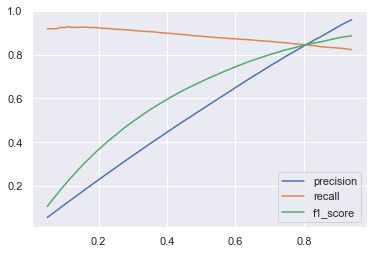

In [357]:
plt.plot(res.accept_rates, res.precision, label='precision')
plt.plot(res.accept_rates, res.recall, label='recall')
plt.plot(res.accept_rates, res.f1_score, label='f1_score')
plt.legend()
plt.show()

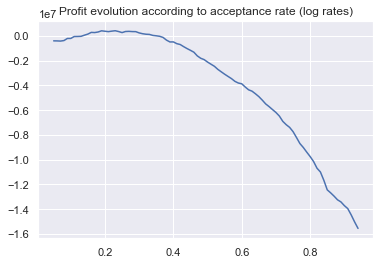

In [358]:
plt.plot(res.accept_rates, res.profit)
plt.title('Profit evolution according to acceptance rate (log rates)')
plt.show()

Set accept rate to approx 35% (bit higher than real max as we will loose contracts because of types of clients).

threshold :  0.1442


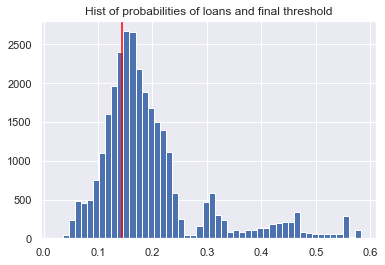

In [313]:
plt.hist(preds['prob_default'], bins = 50)
plt.title('Hist of probabilities of loans and final threshold')
threshold = np.quantile(preds['prob_default'], 0.3)
print('threshold : ', round(threshold, 4))
plt.axvline(x = threshold, color = 'red')
plt.show()

In [350]:
preds['pred_loan_status'] = preds['prob_default'].apply(lambda x: 1 if x > threshold else 0)
print(classification_report(preds['pred_loan_status'], preds['true_loan_status']))
print(confusion_matrix(preds['pred_loan_status'], preds['true_loan_status']))
print('Accuracy Score : ', round(accuracy_score(preds['pred_loan_status'], preds['true_loan_status']),3))

              precision    recall  f1-score   support

           0       0.96      0.82      0.89     28200
           1       0.14      0.45      0.21      1800

    accuracy                           0.80     30000
   macro avg       0.55      0.64      0.55     30000
weighted avg       0.91      0.80      0.85     30000

[[23198  5002]
 [  984   816]]
Accuracy Score :  0.8


In [351]:
print(metrics.precision_score(preds['pred_loan_status'], preds['true_loan_status'], pos_label=0))
#metrics.recall_score(preds['pred_loan_status'], preds['true_loan_status'])
#metrics.f1_score(preds['pred_loan_status'], preds['true_loan_status'])

0.9593085766272434


Accuracy is worse but there is a much lower number of false positives

## Apply to dataset

In [315]:
upload = pd.read_csv('LoanApplications_Stage1_Lender3.csv')
data = upload

In [316]:
data = pd.get_dummies(data)
data = data.drop(['id'], axis=1)
data['log_income'] = np.log(data['income']+1)
data = data.loc[:, data.columns != 'income']

In [317]:
data.head(5)

,sex,marital,social3,employment_employed,employment_retired,employment_student,employment_unemployed,log_income
0,1,1,0.889338,1,0,0,0,8.960339
1,1,1,0.223372,0,1,0,0,9.136371
2,1,1,0.000000,1,0,0,0,10.149840
3,1,1,0.274015,1,0,0,0,10.962354
4,1,0,0.208616,0,1,0,0,8.279951


In [318]:
data_pred = pd.DataFrame(model.predict_proba(data)[:,1], columns = ['prob_default'])
data_pred['pred_loan_status'] = data_pred['prob_default'].apply(lambda x: 1 if x > threshold else 0)
rate = data_pred['prob_default']
data_pred['rate'] = 0.95 * np.log(1+rate)
data_pred.loc[data_pred['pred_loan_status'] == 1, 'rate'] = float("Inf")

In [319]:
data_pred

,prob_default,pred_loan_status,rate
0,0.132435,0,0.118152
1,0.161698,1,inf
2,0.188528,1,inf
3,0.138246,0,0.123014
4,0.203398,1,inf
...,...,...,...
99995,0.145444,1,inf
99996,0.290408,1,inf
99997,0.162268,1,inf
99998,0.101514,0,0.091851


Mean of rates : 10.2 %
Number of loans granted : 30514


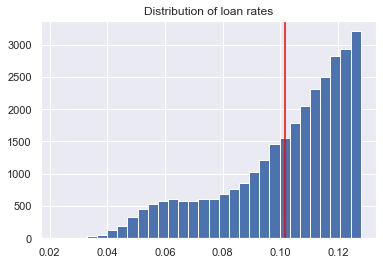

In [320]:
plt.hist(data_pred[data_pred['rate'] != float("Inf")]['rate'], bins = 30)
plt.title('Distribution of loan rates')
print('Mean of rates :', 100*round(data_pred[data_pred != float("Inf")]['rate'].mean(),3), '%')
print('Number of loans granted :', len(data_pred[data_pred['rate'] != float("Inf")]))

plt.axvline(x = data_pred[data_pred != float("Inf")]['rate'].mean(), color = 'red')
plt.show()

In [321]:
upload['rate'] = round(data_pred['rate'],3)

In [322]:
upload

,id,sex,employment,marital,income,social3,rate
0,100001,1,employed,1,7787,0.889338,0.118
1,100002,1,retired,1,9286,0.223372,inf
2,100003,1,employed,1,25586,0.000000,inf
3,100004,1,employed,1,57661,0.274015,0.123
4,100005,1,retired,0,3943,0.208616,inf
...,...,...,...,...,...,...,...
99995,199996,1,retired,0,22188,0.279188,inf
99996,199997,1,student,0,0,0.984142,inf
99997,199998,1,employed,1,5615,0.659528,inf
99998,199999,1,unemployed,1,16573,0.557966,0.092


In [323]:
upload.to_csv('pred_Stage1_Lender3',index=False)